In [1]:
from matplotlib import pyplot
from math import pi
import numpy
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16
import numba
from numba import jit

In [2]:
@jit
def Fc1(u,v,dx,dy):
    F=numpy.zeros(numpy.shape(u))
    F[1:-1,1:-1]=-((u[1:-1,1:-1]+u[1:-1,2:])**2-(u[1:-1,1:-1]+u[1:-1,:-2])**2)/(4*dx)-\
                  ((u[1:-1,1:-1]+u[2:,1:-1])*(v[1:-1,2:]+v[1:-1,1:-1])-\
                  (u[1:-1,1:-1]+u[:-2,1:-1])*(v[:-2,2:]+v[:-2,1:-1]))/(4*dy)
        
    F[:,0]=-F[:,1]
    F[:,-1]=-F[:,-2]
    F[0,:]=-F[1,:]
    F[-1,:]=-F[-2,:]
    return F

In [3]:
@jit
def Fv1(u,v,dx,dy):
    F=numpy.zeros(numpy.shape(u))
    F[1:-1,1:-1]=((u[1:-1,2:]-2*u[1:-1,1:-1]+u[1:-1,:-2])/dx**2+\
                 (u[2:,1:-1]-2*u[1:-1,1:-1]+u[:-2,1:-1])/dy**2)/100
    
    F[:,0]=-F[:,1]
    F[:,-1]=-F[:,-2]
    F[0,:]=-F[1,:]
    F[-1,:]=-F[-2,:]
    return F

In [4]:
@jit
def Fp1(p,dx,dy):
    F=numpy.zeros(numpy.shape(p))
    F[1:-1,1:-1]=-(p[1:-1,2:]-p[1:-1,1:-1])/dx
    F[:,0]=-F[:,1]
    F[:,-1]=-F[:,-2]
    F[0,:]=-F[1,:]
    F[-1,:]=-F[-2,:]
    return F

In [5]:
@jit
def Fc2(u,v,dx,dy):
    F=numpy.zeros((numpy.shape(u)))
    F[1:-1,1:-1]=-((u[2:,1:-1]+u[1:-1,1:-1])*(v[1:-1,1:-1]+v[1:-1,2:])-\
                   (u[2:,:-2]+u[1:-1,:-2])*(v[1:-1,1:-1]+v[1:-1,:-2]))/(4*dx)-\
                  ((v[1:-1,1:-1]+[v[2:,1:-1]])**2-(v[1:-1,1:-1]+v[:-2,1:-1])**2)/(4*dy)
        
    F[:,0]=-F[:,1]
    F[:,-1]=-F[:,-2]
    F[0,:]=-F[1,:]
    F[-1,:]=-F[-2,:]
    return F

In [6]:
@jit
def Fv2(u,v,dx,dy):
    F=numpy.zeros((numpy.shape(u)))
    F[1:-1,1:-1]=((v[1:-1,2:]-2*v[1:-1,1:-1]+v[1:-1,:-2])/dx**2+\
                 (v[2:,1:-1]-2*v[1:-1,1:-1]+v[:-2,1:-1])/dy**2)/100
        
    F[:,0]=-F[:,1]
    F[:,-1]=-F[:,-2]
    F[0,:]=-F[1,:]
    F[-1,:]=-F[-2,:]
    return F

In [7]:
@jit
def Fp2(p,dx,dy):
    F=numpy.zeros((numpy.shape(p)))
    F[1:-1,1:-1]=-(p[2:,1:-1]-p[1:-1,1:-1])/dy
        
    F[:,0]=-F[:,1]
    F[:,-1]=-F[:,-2]
    F[0,:]=-F[1,:]
    F[-1,:]=-F[-2,:]
    return F

In [8]:
@jit
def poisson(f,omega):
    nj,ni=numpy.shape(f)-numpy.array((1,1))
    dx=1./(ni-1)
    dy=1./(nj-1)
    x=numpy.linspace(-dx/2,1+dx/2,ni+1)
    y=numpy.linspace(-dy/2,1+dy/2,nj+1)
    X,Y=numpy.meshgrid(x,y)
    p=numpy.zeros(numpy.shape(f))
    res=numpy.zeros(numpy.shape(f))
    
    res_max=1e3
    
    while res_max>1e-6:
        
        for j in range(1,nj):
            for i in range(1,ni):
                p[j,i]=omega/(2*(dx**2+dy**2))*((p[j,i-1]+p[j,i+1])*dy**2+\
                       (p[j-1,i]+p[j+1,i])*dx**2-f[j,i]*dx**2*dy**2)+\
                       (1-omega)*p[j,i]
        p[0,:]=-p[1,:]
        p[-1,:]=-p[-2,:]
        p[:,0]=-p[:,1]
        p[:,-1]=-p[:,-2]
        
        for j in range(1,nj):
            for i in range(1,ni):
                res[j,i]=numpy.abs(f[j,i]-(p[j,i-1]-2*p[j,i]+p[j,i+1])/dx**2-\
                                  (p[j-1,i]-2*p[j,i]+p[j+1,i])/dy**2)
        res_max=numpy.max(res)
    
    return p

In [9]:
@jit
def getuv(w1,w2,p,dx,dy,dt):
    u=w1+Fp1(p,dx,dy)*dt
    v=w2+Fp2(p,dx,dy)*dt
    
    u[0,:]=-u[1,:]
    u[-1,:]=2-u[-2,:]
    u[:,0]=0
    u[:,-2]=0
    u[:,-1]=-u[:,-3]

    v[:,0]=-v[:,1]
    v[:,-1]=-v[:,-2]
    v[0,:]=0
    v[-2,:]=0
    v[-1,:]=-v[-3,:]
    
    return u,v

In [10]:
@jit
def difference(p,pold):
    nj,ni=numpy.shape(p)-numpy.array((1,1))
    diff=numpy.zeros(numpy.shape(p))
    for j in range(nj+1):
        for i in range(ni+1):
            diff[j,i]=numpy.abs(p[j,i]-pold[j,i])
    diff_max=numpy.max(diff)
    return diff_max

In [11]:
def grid_p(ni,nj):
    dx=1./(ni-1)
    dy=1./(nj-1)
    x=numpy.linspace(-dx/2,1+dx/2,ni+1)
    y=numpy.linspace(-dy/2,1+dy/2,nj+1)
    X,Y=numpy.meshgrid(x,y)
    return X,Y

def grid_u(ni,nj):
    dx=1./(ni-1)
    dy=1./(nj-1)
    xu=numpy.linspace(0,1+dx,ni+1)
    yu=numpy.linspace(-dy/2,1+dy/2,nj+1)
    X,Y=numpy.meshgrid(xu,yu)
    return X,Y

def grid_v(ni,nj):
    dx=1./(ni-1)
    dy=1./(nj-1)
    xv=numpy.linspace(-dx/2,1+dx/2,ni+1)
    yv=numpy.linspace(0,1+dy,nj+1)
    X,Y=numpy.meshgrid(xv,yv)
    return X,Y

In [12]:
@jit
def RK3(ni,nj,dt):
    
    dx=1./(ni-1)
    dy=1./(nj-1)
    x=numpy.linspace(-dx/2,1+dx/2,ni+1)
    y=numpy.linspace(-dy/2,1+dy/2,nj+1)
    xu=numpy.linspace(0,1+dx,ni+1)
    yu=numpy.linspace(-dy/2,1+dy/2,nj+1)
    xv=numpy.linspace(-dx/2,1+dx/2,ni+1)
    yv=numpy.linspace(0,1+dy,nj+1)

    X,Y=numpy.meshgrid(x,y)
    Xu,Yu=numpy.meshgrid(xu,yu)
    Xv,Yv=numpy.meshgrid(xv,yv)

    u0=numpy.zeros((nj+1,ni+1))
    v0=numpy.zeros((nj+1,ni+1))
    u0[-1,1:-3]=2.
    p0=numpy.zeros((nj+1,ni+1))
    omega0=numpy.zeros((nj+1,ni+1))
            
    u=u0.copy()
    v=v0.copy()
    p=p0.copy()
    omega=omega0.copy()
    
    G1=numpy.zeros((nj+1,ni+1))
    G2=numpy.zeros((nj+1,ni+1))
    w1=numpy.zeros((nj+1,ni+1))
    w2=numpy.zeros((nj+1,ni+1)) 
    f=numpy.zeros((nj+1,ni+1))
    
    t=0.
    nt=0
    uold=numpy.ones((nj+1,ni+1))
    vold=numpy.ones((nj+1,ni+1))
    pold=numpy.ones((nj+1,ni+1))
    
    while difference(u,uold)>1e-6:
        uold=u.copy()
        vold=v.copy()
        pold=p.copy()
        
        #from t to t+dt/3
        #t+=dt/3
        G1=Fc1(u,v,dx,dy)+Fv1(u,v,dx,dy)
        G2=Fc2(u,v,dx,dy)+Fv2(u,v,dx,dy)
        w1=u+dt/3*G1
        w2=v+dt/3*G2
        f[1:-1,1:-1]=3./dt*((w1[1:-1,1:-1]-w1[1:-1,:-2])/dx+(w2[1:-1,1:-1]-w2[:-2,1:-1])/dy)
        p=poisson(f,1.85)
        u,v=getuv(w1,w2,p,dx,dy,dt/3)
        
        #from t+dt/3 to t+3dt/4
        #t+=5/12*dt
        G1=-5./9*G1+Fc1(u,v,dx,dy)+Fv1(u,v,dx,dy)
        G2=-5./9*G2+Fc2(u,v,dx,dy)+Fv2(u,v,dx,dy)
        w1=u+dt*15./16*G1
        w2=v+dt*15./16*G2
        f[1:-1,1:-1]=12./5/dt*((w1[1:-1,1:-1]-w1[1:-1,:-2])/dx+(w2[1:-1,1:-1]-w2[:-2,1:-1])/dy)        
        p=poisson(f,1.85)
        u,v=getuv(w1,w2,p,dx,dy,5*dt/12)
        
        #from t+3dt/4 to t+dt
        #t+=dt/4
        G1=-153./128*G1+Fc1(u,v,dx,dy)+Fv1(u,v,dx,dy)
        G2=-153./128*G2+Fc2(u,v,dx,dy)+Fv2(u,v,dx,dy)
        w1=u+dt*8./15*G1
        w2=v+dt*8./15*G2
        f[1:-1,1:-1]=4./dt*((w1[1:-1,1:-1]-w1[1:-1,:-2])/dx+(w2[1:-1,1:-1]-w2[:-2,1:-1])/dy)
        p=poisson(f,1.85)
        u,v=getuv(w1,w2,p,dx,dy,dt/4)
        
        if nt%1000==0:
            print(nt,difference(u,uold))
        nt+=1
        t+=dt
        
    psi=numpy.zeros((nj+1,ni+1))
    for j in range(1,nj+1):
        for i in range(ni+1):
            psi[j,i]=psi[j-1,i]+u[j,i]*dy
        
    return u,v,p,psi

In [13]:
#point no. and u,v values in the reference 
yuc=numpy.array([0,7,8,9,13,22,36,58,64,79,94,109,122,123,124,125,128])
xvc=numpy.array([0,8,9,10,12,20,29,30,64,103,110,116,121,122,123,124,128])
uref=numpy.array([0.,-0.03717,-0.04192,-0.04775,-0.06434,-0.10150,-0.15662,\
                 -0.21090,-0.20581,-0.13641,0.00332,0.23151,0.68717,0.73722,\
                0.78871,0.84123,1.])
vref=numpy.array([0.,0.09233,0.10091,0.10890,0.12317,0.16077,0.17507,0.17527,\
                 0.05454,-0.24533,-0.22445,-0.16914,-0.10313,-0.08864,-0.07391,\
                 -0.05906,0.])

In [14]:
u1,v1,p1,psi1=RK3(129,129,1e-3,1)

0 1.86059811635
500 0.00041245318064


In [15]:
u2,v2,p2,psi2=RK3(129,129,1e-3,2)

0 1.86059811635
500 0.00041245318064
1000 0.000178400726433
1500 9.7311304364e-05
2000 6.05058437668e-05


In [16]:
u3,v3,p3,psi3=RK3(129,129,1e-3,4)

0 1.86059811635
500 0.00041245318064
1000 0.000178400726433
1500 9.7311304364e-05
2000 6.05058437668e-05
2500 4.08672754312e-05
3000 2.88843260476e-05
3500 2.09520650851e-05
4000 1.54766375155e-05


In [17]:
u4,v4,p4,psi4=RK3(129,129,1e-3,8)

0 1.86059811635
500 0.00041245318064
1000 0.000178400726433
1500 9.7311304364e-05
2000 6.05058437668e-05
2500 4.08672754312e-05
3000 2.88843260476e-05
3500 2.09520650851e-05
4000 1.54766375155e-05
4500 1.1573882566e-05
5000 8.72796950399e-06
5500 6.62125916946e-06
6000 5.04044719226e-06
6500 3.84520592148e-06
7000 2.93699202555e-06
7500 2.2450430145e-06


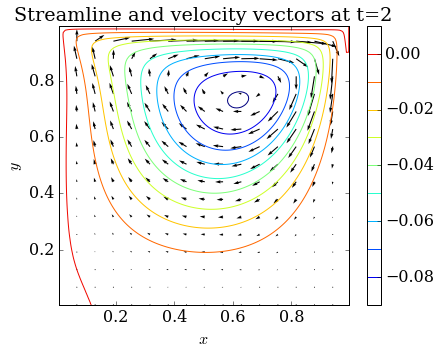

In [18]:
X,Y=grid_p(129,129)
Xu,Yu=grid_u(129,129)
Xv,Yv=grid_v(129,129)

pyplot.figure(figsize=(6.5,5))
pyplot.contour(X[1:-1,1:-1],Y[1:-1,1:-1],psi4[1:-1,1:-1],10)
pyplot.xlabel('$x$')
pyplot.ylabel('$y$')
pyplot.colorbar()
pyplot.quiver(X[1:-1:8,1:-1:8],Y[1:-1:8,1:-1:8],u2[1:-1:8,1:-1:8],v2[1:-1:8,1:-1:8],scale=5)
pyplot.title('Streamline and velocity vectors at t=2');

In [19]:
#center values
uc1=(u1[:,64]+u1[:,65])/2
vc1=(v1[64,:]+v1[65,:])/2

#find average value of each two points 
uver1=numpy.zeros(129)
for j in range(129):
    uver1[j]=(uc1[j+1]+uc1[j])/2

vhor1=numpy.zeros(129)
for i in range(129):
    vhor1[i]=(vc1[i+1]+vc1[i])/2
    
#corresponding point u,v values during my computation
ucver1=numpy.zeros(numpy.shape(uref))
for j in range(17):
    ucver1[j]=uver1[yuc[j]]
    
vchor1=numpy.zeros(numpy.shape(vref))
for i in range(17):
    vchor1[i]=vhor1[xvc[i]]

In [20]:
#center values
uc2=(u2[:,64]+u2[:,65])/2
vc2=(v2[64,:]+v2[65,:])/2

#find average value of each two points 
uver2=numpy.zeros(129)
for j in range(129):
    uver2[j]=(uc2[j+1]+uc2[j])/2
    
vhor2=numpy.zeros(129)
for i in range(129):
    vhor2[i]=(vc2[i+1]+vc2[i])/2
    
#corresponding point u,v values during my computation
ucver2=numpy.zeros(numpy.shape(uref))
for j in range(17):
    ucver2[j]=uver2[yuc[j]]
    
vchor2=numpy.zeros(numpy.shape(vref))
for i in range(17):
    vchor2[i]=vhor2[xvc[i]]

In [21]:
#center values
uc3=(u3[:,64]+u3[:,65])/2
vc3=(v3[64,:]+v3[65,:])/2

#find average value of each two points 
uver3=numpy.zeros(129)
for j in range(129):
    uver3[j]=(uc3[j+1]+uc3[j])/2
    
vhor3=numpy.zeros(129)
for i in range(129):
    vhor3[i]=(vc3[i+1]+vc3[i])/2
    
#corresponding point u,v values during my computation
ucver3=numpy.zeros(numpy.shape(uref))
for j in range(17):
    ucver3[j]=uver3[yuc[j]]
    
vchor3=numpy.zeros(numpy.shape(vref))
for i in range(17):
    vchor3[i]=vhor3[xvc[i]]

In [23]:
#center values
uc4=(u4[:,64]+u4[:,65])/2
vc4=(v4[64,:]+v4[65,:])/2

#find average value of each two points 
uver4=numpy.zeros(129)
for j in range(129):
    uver4[j]=(uc4[j+1]+uc4[j])/2
    
vhor4=numpy.zeros(129)
for i in range(129):
    vhor4[i]=(vc4[i+1]+vc4[i])/2
    
#corresponding point u,v values during my computation
ucver4=numpy.zeros(numpy.shape(uref))
for j in range(17):
    ucver4[j]=uver4[yuc[j]]
    
vchor4=numpy.zeros(numpy.shape(vref))
for i in range(17):
    vchor4[i]=vhor4[xvc[i]]

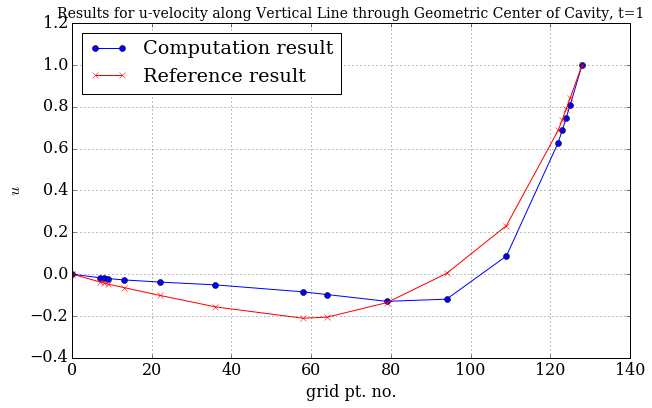

In [24]:
pyplot.figure(figsize=(10,6))
pyplot.grid(True)
pyplot.xlabel('grid pt. no.')
pyplot.ylabel('$u$')
pyplot.plot(yuc,ucver1,color='b',marker='o')
pyplot.plot(yuc,uref,color='r',marker='x')
pyplot.title('Results for u-velocity along Vertical Line through Geometric Center of Cavity, t=1',fontsize=14)
pyplot.legend(['Computation result','Reference result'],loc='best');

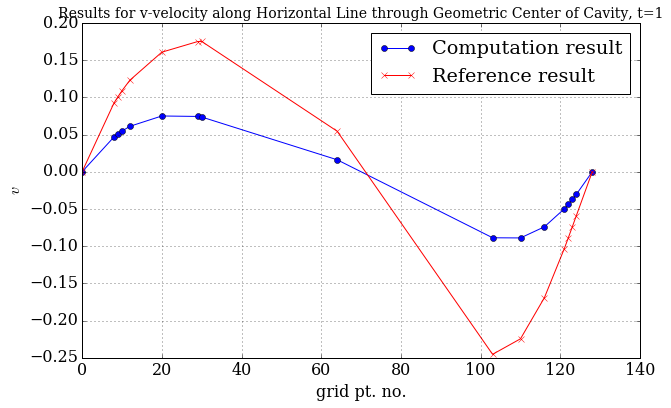

In [25]:
pyplot.figure(figsize=(10,6))
pyplot.grid(True)
pyplot.xlabel('grid pt. no.')
pyplot.ylabel('$v$')
pyplot.plot(xvc,vchor1,color='b',marker='o')
pyplot.plot(xvc,vref,color='r',marker='x')
pyplot.title('Results for v-velocity along Horizontal Line through Geometric Center of Cavity, t=1',fontsize=14)
pyplot.legend(['Computation result','Reference result'],loc='best');

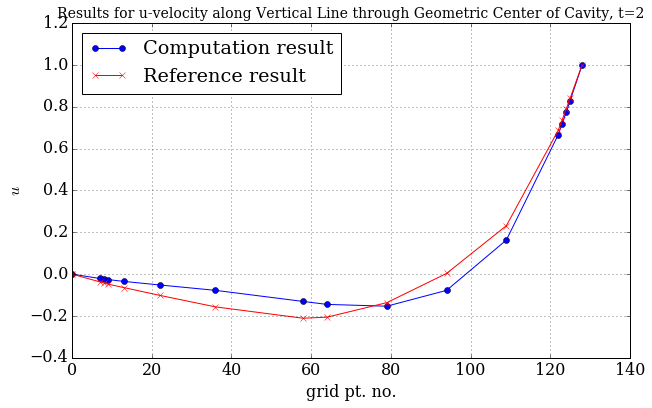

In [26]:
pyplot.figure(figsize=(10,6))
pyplot.grid(True)
pyplot.xlabel('grid pt. no.')
pyplot.ylabel('$u$')
pyplot.plot(yuc,ucver2,color='b',marker='o')
pyplot.plot(yuc,uref,color='r',marker='x')
pyplot.title('Results for u-velocity along Vertical Line through Geometric Center of Cavity, t=2',fontsize=14)
pyplot.legend(['Computation result','Reference result'],loc='best');

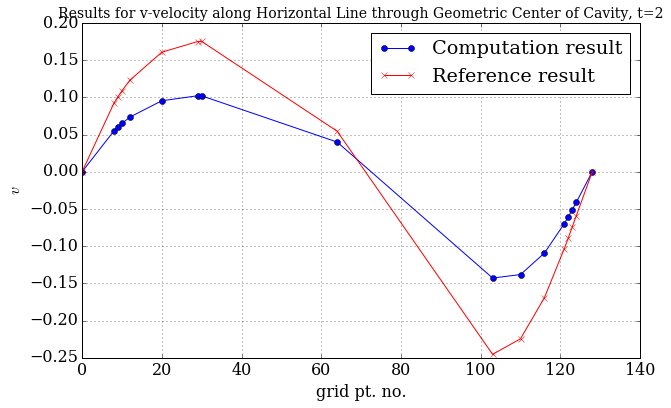

In [27]:
pyplot.figure(figsize=(10,6))
pyplot.grid(True)
pyplot.xlabel('grid pt. no.')
pyplot.ylabel('$v$')
pyplot.plot(xvc,vchor2,color='b',marker='o')
pyplot.plot(xvc,vref,color='r',marker='x')
pyplot.title('Results for v-velocity along Horizontal Line through Geometric Center of Cavity, t=2',fontsize=14)
pyplot.legend(['Computation result','Reference result'],loc='best');

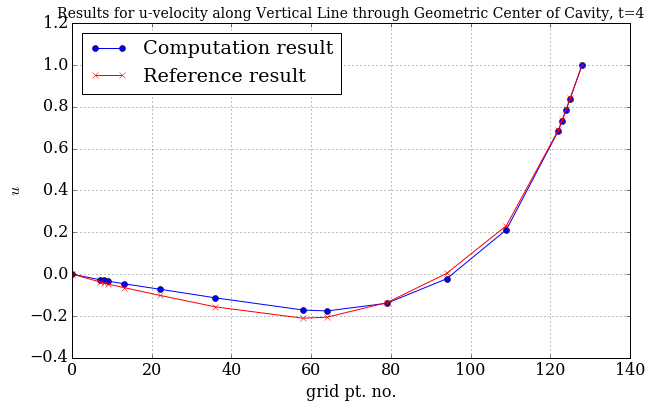

In [28]:
pyplot.figure(figsize=(10,6))
pyplot.grid(True)
pyplot.xlabel('grid pt. no.')
pyplot.ylabel('$u$')
pyplot.plot(yuc,ucver3,color='b',marker='o')
pyplot.plot(yuc,uref,color='r',marker='x')
pyplot.title('Results for u-velocity along Vertical Line through Geometric Center of Cavity, t=4',fontsize=14)
pyplot.legend(['Computation result','Reference result'],loc='best');

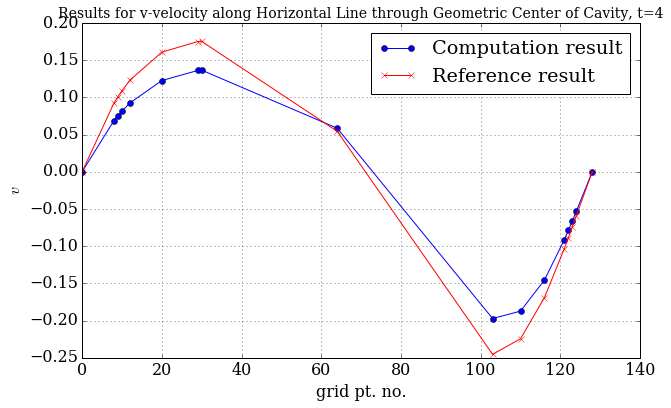

In [29]:
pyplot.figure(figsize=(10,6))
pyplot.grid(True)
pyplot.xlabel('grid pt. no.')
pyplot.ylabel('$v$')
pyplot.plot(xvc,vchor3,color='b',marker='o')
pyplot.plot(xvc,vref,color='r',marker='x')
pyplot.title('Results for v-velocity along Horizontal Line through Geometric Center of Cavity, t=4',fontsize=14)
pyplot.legend(['Computation result','Reference result'],loc='best');

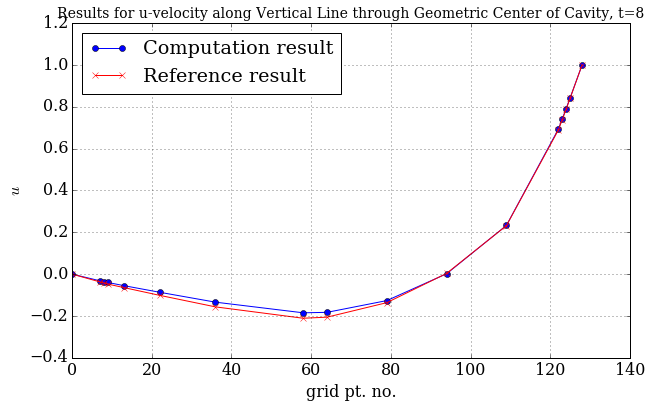

In [30]:
pyplot.figure(figsize=(10,6))
pyplot.grid(True)
pyplot.xlabel('grid pt. no.')
pyplot.ylabel('$u$')
pyplot.plot(yuc,ucver4,color='b',marker='o')
pyplot.plot(yuc,uref,color='r',marker='x')
pyplot.title('Results for u-velocity along Vertical Line through Geometric Center of Cavity, t=8',fontsize=14)
pyplot.legend(['Computation result','Reference result'],loc='best');

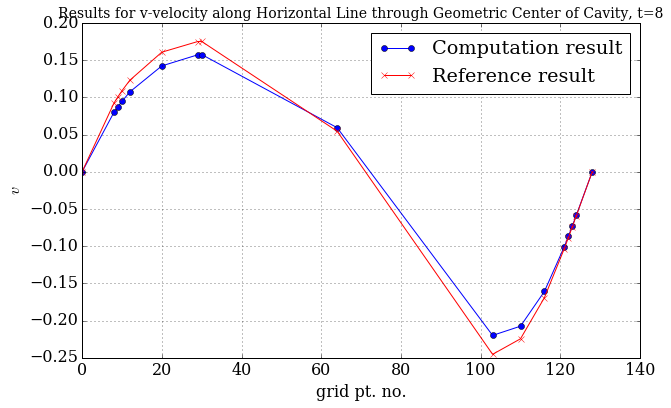

In [31]:
pyplot.figure(figsize=(10,6))
pyplot.grid(True)
pyplot.xlabel('grid pt. no.')
pyplot.ylabel('$v$')
pyplot.plot(xvc,vchor4,color='b',marker='o')
pyplot.plot(xvc,vref,color='r',marker='x')
pyplot.title('Results for v-velocity along Horizontal Line through Geometric Center of Cavity, t=8',fontsize=14)
pyplot.legend(['Computation result','Reference result'],loc='best');

In [32]:
print(ucver4)
print(vchor4)

[ 0.         -0.03188248 -0.03595094 -0.0399291  -0.05510979 -0.08680038
 -0.13412005 -0.18493233 -0.18275894 -0.12655871  0.00163157  0.23234236
  0.69143596  0.7407387   0.79132242  0.84281005  1.        ]
[ 0.          0.0799321   0.0875323   0.09464372  0.10746124  0.14231608
  0.15722464  0.15765168  0.05927097 -0.21988851 -0.20750145 -0.16076635
 -0.10046433 -0.08678687 -0.07274838 -0.05843044  0.        ]
